In [ ]:
# Imports
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# load in the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# make sure that the data is all the right shape
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

# One hot encode the output data
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

Augmenting training data...
Aug iteration 0: x_train shape = (120000, 28, 28, 1), y_train shape = (120000, 10)
Aug iteration 1: x_train shape = (180000, 28, 28, 1), y_train shape = (180000, 10)
Augmenting test data...
Aug iteration 0: x_test_aug shape = (20000, 28, 28, 1), y_test_aug shape = (20000, 10)
Aug iteration 1: x_test_aug shape = (30000, 28, 28, 1), y_test_aug shape = (30000, 10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model created and compiled
Epoch 1/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.7945 - loss: 0.6619 - val_accuracy: 0.8995 - val_loss: 0.3585 - learning_rate: 0.0010
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8868 - loss: 0.4066 - val_accuracy: 0.9115 - val_loss: 0.3539 - learning_rate: 0.0010
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8994 - loss: 0.3919 - val_accuracy: 0.9262 - val_loss: 0.3333 - learning_rate: 0.0010
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9083 - loss: 0.3824 - val_accuracy: 0.9233 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9103 - loss: 0.3794 - val_accuracy: 0.9237 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9137 - loss: 0.3728 - val_accuracy: 0.9262 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1

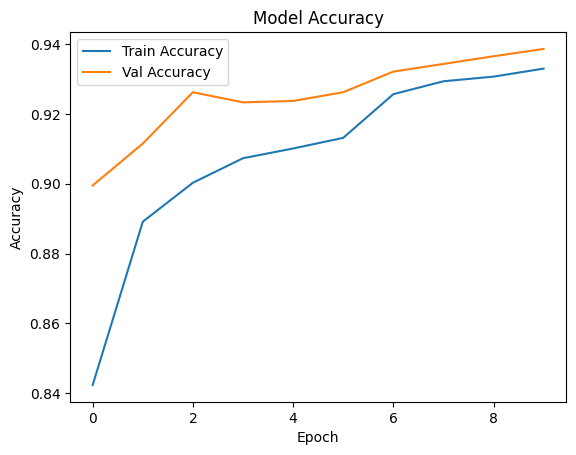

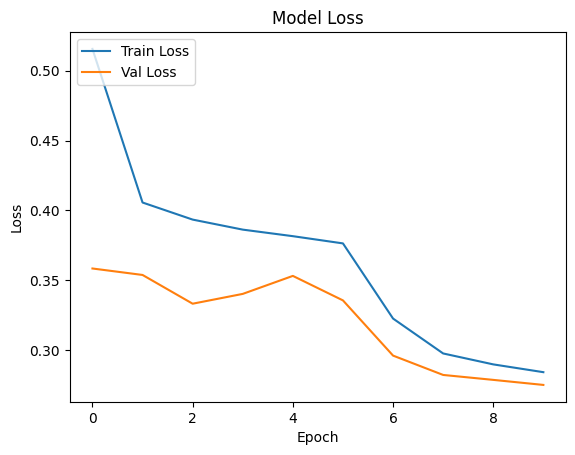

In [ ]:
# === 3. Data Augmentation Setup (Manual Concatenation) ===
train_gen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    shear_range=0.3,
    height_shift_range=0.08,
    zoom_range=0.08
)

test_gen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    shear_range=0.3,
    height_shift_range=0.08,
    zoom_range=0.08
)

x_train_aug = x_train.copy()
y_train_aug = y_train.copy()
x_test_aug  = x_test.copy()
y_test_aug  = y_test.copy()

# Generate augmented images for train data
train_set = train_gen.flow(x_train_aug, y_train_aug, batch_size=x_train_aug.shape[0])

# Generate augmented images for test data
test_set  = test_gen.flow(x_test_aug, y_test_aug, batch_size=x_test_aug.shape[0])

# Concatenate a few augmented batches to original data
aug_iterations = 2
print("Augmenting training data...")
i = 0
for x_batch, y_batch in train_set:
    if i < aug_iterations:
        x_train = np.concatenate((x_train, x_batch))
        y_train = np.concatenate((y_train, y_batch))
        print(f"Aug iteration {i}: x_train shape = {x_train.shape}, y_train shape = {y_train.shape}")
    else:
        break
    i += 1

print("Augmenting test data...")
i = 0
for x_batch, y_batch in test_set:
    if i < aug_iterations:
        x_test_aug = np.concatenate((x_test_aug, x_batch))
        y_test_aug = np.concatenate((y_test_aug, y_batch))
        print(f"Aug iteration {i}: x_test_aug shape = {x_test_aug.shape}, y_test_aug shape = {y_test_aug.shape}")
    else:
        break
    i += 1

tf.keras.backend.clear_session()

# === 4. Build an Improved CNN Model with L2 Regularization ===
# You can adjust the L2 factor (e.g., 1e-4) to be stronger/weaker
weight_decay = 1e-4

model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(weight_decay), input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully connected
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Typically no regularizer needed for final layer
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model created and compiled")

# === 5. Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# === 6. Train the Model ===
history = model.fit(
    x_train, y_train,
    epochs= 10,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr]
)
print("Model fitted")

# === 7. Plot Training History ===
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()